Import dependencies

In [894]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from IPython.display import display
from sklearn.preprocessing import OneHotEncoder
import torch
from transformers import AutoProcessor, CLIPModel


Load the data

In [2]:
airbnb = pd.read_csv("airbnb-listings.csv", delimiter=";")


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,2,27,66) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Check the shape

In [3]:
airbnb.shape

(494954, 89)

Check the head

In [4]:
pd.set_option('display.max_columns', None)
airbnb.head()

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,Notes,Transit,Access,Interaction,House Rules,Thumbnail Url,Medium Url,Picture Url,XL Picture Url,Host ID,Host URL,Host Name,Host Since,Host Location,Host About,Host Response Time,Host Response Rate,Host Acceptance Rate,Host Thumbnail Url,Host Picture Url,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Host Verifications,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Square Feet,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Has Availability,Availability 30,Availability 60,Availability 90,Availability 365,Calendar last Scraped,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,6017649,https://www.airbnb.com/rooms/6017649,20170402075052,2017-04-02,Nice room at Vondelpark,Nice and clean private bedroom near the city c...,"I offer a cuzy, private room in a nice apartme...",Nice and clean private bedroom near the city c...,none,Really nice and quiet nighborhood!,NaN,Directly train connection to Central Station a...,Acces to shared use of the bathroom facilities...,NaN,NaN,https://a0.muscache.com/im/pictures/74942550/4...,https://a0.muscache.com/im/pictures/74942550/4...,https://public.opendatasoft.com/api/explore/v2...,https://a0.muscache.com/im/pictures/74942550/4...,1195000,https://www.airbnb.com/users/show/1195000,Linda,2011-09-22,"Amsterdam, North Holland, Netherlands",NaN,NaN,NaN,NaN,https://a0.muscache.com/im/users/1195000/profi...,https://a0.muscache.com/im/users/1195000/profi...,NaN,1.0,1.0,"email,phone,facebook,reviews","Amsterdam, Noord-Holland 1054, Netherlands",NaN,De Baarsjes - Oud-West,NaN,Amsterdam,Noord-Holland,1054,Amsterdam,"Amsterdam, Netherlands",NL,Netherlands,52.359927,4.862860,Apartment,Private room,1.0,1.0,1.0,1.0,Real Bed,"Internet,Wireless Internet,Kitchen,Heating,Was...",NaN,50.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0,1125.0,22 months ago,NaN,0.0,0.0,0.0,0.0,2017-04-02,3.0,2015-05-10,2015-06-08,90.0,10.0,9.0,10.0,9.0,9.0,9.0,NaN,Amsterdam,flexible,1.0,0.13,"52.35992696894107, 4.862859671199358",Host Has Profile Pic
1,9192415,https://www.airbnb.com/rooms/9192415,20170402075052,2017-04-02,Cozy apartment center Amsterdam,Cozy 2 person apartment in Amsterdam on walkin...,"The appartment has a living room, a kitchen, a...",Cozy 2 person apartment in Amsterdam on walkin...,none,This is an apartment situated at the West side...,NaN,"Vondelpark, Museum Square, Leidsplein is on wa...",NaN,NaN,"-smoking in the house is strictly forbidden, b...",https://a0.muscache.com/im/pictures/eb9e20e1-9...,https://a0.muscache.com/im/pictures/eb9e20e1-9...,https://public.opendatasoft.com/api/explore/v2...,https://a0.muscache.com/im/pictures/eb9e20e1-9...,47820987,https://www.airbnb.com/users/show/47820987,Annabel,2015-10-31,"Amsterdam, North Holland, Netherlands","I'm from belgian, but currently living in Amst...",within a few hours,100.0,NaN,https://a0.muscache.com/im/pictures/0fc41f38-7...,https://a0.muscache.com/im/pictures/0fc41f38-7...,Oud-West,1.0,1.0,"email,phone,reviews,jumio,government_id","Oud-West, Amsterdam, Noord-Holland 1054 HP, Ne...",Oud-West,De Baarsjes - Oud-West,NaN,Amsterdam,Noord-Holland,1054 HP,Amsterdam,"Amsterdam, Netherlands",NL,Netherlands,52.361371,4.873860,Apartment,Entire home/apt,2.0,1.0,1.0,1.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",NaN,95.0,NaN,NaN,NaN,15.0,2.0,40.0,2.0,7.0,2 months ago,NaN,0.0,0.0,0.0,0.0,2017-04-02,

DATA PREPROCESSING

Select columns that will be included in the predictive model

In [5]:
relevant_columns = [15,8,22,25,26,27,31,33,38,39,41,44,47,48,49,50,51,52,53,54,55,56,
                    59,60,61,62,63,64,65,66,67,68,69,70,72,75,76,77,78,79,80,81,82,84,86,88]
airbnb2 = airbnb.iloc[:,relevant_columns]
airbnb2.head()

,Thumbnail Url,Experiences Offered,Host Since,Host Response Time,Host Response Rate,Host Acceptance Rate,Host Listings Count,Host Verifications,City,State,Market,Country,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Square Feet,Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Has Availability,Availability 30,Availability 60,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Cancellation Policy,Reviews per Month,Features
0,https://a0.muscache.com/im/pictures/74942550/4...,none,2011-09-22,NaN,NaN,NaN,1.0,"email,phone,facebook,reviews",Amsterdam,Noord-Holland,Amsterdam,Netherlands,Apartment,Private room,1.0,1.0,1.0,1.0,Real Bed,"Internet,Wireless Internet,Kitchen,Heating,Was...",NaN,50.0,NaN,NaN,1.0,0.0,1.0,1125.0,22 months ago,NaN,0.0,0.0,0.0,0.0,3.0,90.0,10.0,9.0,10.0,9.0,9.0,9.0,NaN,flexible,0.13,Host Has Profile Pic
1,https://a0.muscache.com/im/pictures/eb9e20e1-9...,none,2015-10-31,within a few hours,100.0,NaN,1.0,"email,phone,reviews,jumio,government_id",Amsterdam,Noord-Holland,Amsterdam,Netherlands,Apartment,Entire home/apt,2.0,1.0,1.0,1.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",NaN,95.0,NaN,15.0,2.0,40.0,2.0,7.0,2 months ago,NaN,0.0,0.0,0.0,0.0,16.0,99.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,moderate,0.99,"Host Is Superhost,Host Has Profile Pic,Host Id..."
2,https://a0.muscache.com/im/pictures/10232036/f...,none,2012-10-17,within a day,100.0,NaN,3.0,"email,phone,reviews",Amsterdam,North Holland,Amsterdam,Netherlands,Bed & Breakfast,Private room,2.0,1.0,1.0,1.0,Real Bed,"TV,Internet,Wireless Internet,Breakfast,Heatin...",323.0,160.0,NaN,NaN,1.0,0.0,2.0,14.0,today,NaN,3.0,4.0,13.0,178.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,strict,NaN,"Host Has Profile Pic,Is Location Exact"
3,https://a0.muscache.com/im/pictures/4aad80ac-8...,none,2014-07-04,within a few hours,100.0,NaN,1.0,"email,phone,reviews,jumio,offline_government_i...",Amsterdam,Noord-Holland,Amsterdam,Netherlands,Apartment,Entire home/apt,4.0,1.0,2.0,3.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",NaN,175.0,250.0,50.0,2.0,40.0,12.0,21.0,5 weeks ago,NaN,1.0,1.0,1.0,148.0,1.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,strict,0.11,"Host Has Profile Pic,Host Identity Verified,Is..."
4,https://a0.muscache.com/im/pictures/10553335/6...,none,2011-11-27,within an hour,100.0,NaN,1.0,"email,phone,facebook,reviews,work_email",Amsterdam,North Holland,Amsterdam,Netherlands,Apartment,Entire home/apt,2.0,1.0,1.0,1.0,Real Bed,"Wireless Internet,Kitchen,Hot tub,Buzzer/wirel...",NaN,100.0,NaN,NaN,2.0,15.0,4.0,760.0,2 months ago,NaN,0.0,0.0,0.0,0.0,12.0,96.0,10.0,9.0,10.0,9.0,10.0,10.0,NaN,strict,0.21,"Host Has Profile Pic,Is Location Exact,Instant..."


In [6]:
airbnb2.shape

(494954, 46)

Check removed columns

In [21]:
irrelevant_columns = []
for i in range(len(airbnb.columns)):
    if not i in relevant_columns:
        irrelevant_columns.append(i)   
airbnb.columns[irrelevant_columns]

Index(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary',
       'Space', 'Description', 'Neighborhood Overview', 'Notes', 'Transit',
       'Access', 'Interaction', 'House Rules', 'Medium Url', 'Picture Url',
       'XL Picture Url', 'Host ID', 'Host URL', 'Host Name', 'Host Location',
       'Host About', 'Host Thumbnail Url', 'Host Picture Url',
       'Host Neighbourhood', 'Host Total Listings Count', 'Street',
       'Neighbourhood', 'Neighbourhood Cleansed',
       'Neighbourhood Group Cleansed', 'Zipcode', 'Smart Location',
       'Country Code', 'Latitude', 'Longitude', 'Weekly Price',
       'Monthly Price', 'Calendar last Scraped', 'First Review', 'Last Review',
       'Jurisdiction Names', 'Calculated host listings count', 'Geolocation'],
      dtype='object')

Check for missing values

In [30]:
pd.set_option('display.max_rows', None)
airbnb2.isnull().sum()

Thumbnail Url                   94834
Experiences Offered                 0
Host Since                        505
Host Response Time             115069
Host Response Rate             115070
Host Acceptance Rate           452696
Host Listings Count               505
Host Verifications                336
City                              454
State                           49794
Market                           5655
Country                             3
Property Type                      11
Room Type                           1
Accommodates                       63
Bathrooms                        1526
Bedrooms                          626
Beds                              917
Bed Type                            1
Amenities                        4488
Square Feet                    482745
Price                            7958
Security Deposit               290942
Cleaning Fee                   179239
Guests Included                     2
Extra People                       37
Minimum Nigh

Remove rows without Price or Thumbnail Url

In [31]:
drop_columns = ["Thumbnail Url", "Price"]
airbnb3 = airbnb2.dropna(subset=drop_columns)
len(airbnb3)

394894

Check missing values again

In [32]:
airbnb3.isnull().sum()

Thumbnail Url                       0
Experiences Offered                 0
Host Since                        395
Host Response Time              87489
Host Response Rate              87490
Host Acceptance Rate           359081
Host Listings Count               394
Host Verifications                266
City                              379
State                           38520
Market                           4652
Country                             2
Property Type                       9
Room Type                           0
Accommodates                        1
Bathrooms                        1106
Bedrooms                          476
Beds                              728
Bed Type                            0
Amenities                        3319
Square Feet                    386250
Price                               0
Security Deposit               233694
Cleaning Fee                   144870
Guests Included                     1
Extra People                       14
Minimum Nigh

Drop additional columns due to missing values or because they would make the prediction problem too complex. The latter applies to "City" and "State".

In [902]:
airbnb4 = airbnb3.drop(columns = ["Host Acceptance Rate", "Square Feet", "Security Deposit", "Has Availability", "License", "State", "City"])
airbnb5 = airbnb4.dropna()
airbnb5 = airbnb5.reset_index(drop=True)
airbnb5.head()

,Thumbnail Url,Experiences Offered,Host Since,Host Response Time,Host Response Rate,Host Listings Count,Host Verifications,Market,Country,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Price,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Availability 30,Availability 60,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Cancellation Policy,Reviews per Month,Features
0,https://a0.muscache.com/im/pictures/eb9e20e1-9...,none,2015-10-31,within a few hours,100.0,1.0,"email,phone,reviews,jumio,government_id",Amsterdam,Netherlands,Apartment,Entire home/apt,2.0,1.0,1.0,1.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",95.0,15.0,2.0,40.0,2.0,7.0,2 months ago,0.0,0.0,0.0,0.0,16.0,99.0,10.0,10.0,10.0,10.0,10.0,10.0,moderate,0.99,"Host Is Superhost,Host Has Profile Pic,Host Id..."
1,https://a0.muscache.com/im/pictures/4aad80ac-8...,none,2014-07-04,within a few hours,100.0,1.0,"email,phone,reviews,jumio,offline_government_i...",Amsterdam,Netherlands,Apartment,Entire home/apt,4.0,1.0,2.0,3.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",175.0,50.0,2.0,40.0,12.0,21.0,5 weeks ago,1.0,1.0,1.0,148.0,1.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,strict,0.11,"Host Has Profile Pic,Host Identity Verified,Is..."
2,https://a0.muscache.com/im/pictures/440cb88b-6...,none,2014-04-24,within an hour,100.0,0.0,"email,phone,reviews",Amsterdam,Netherlands,Apartment,Entire home/apt,2.0,1.0,1.0,1.0,Real Bed,"TV,Internet,Wireless Internet,Kitchen,Heating,...",115.0,35.0,1.0,0.0,3.0,14.0,today,0.0,0.0,0.0,22.0,1.0,100.0,10.0,10.0,10.0,10.0,8.0,8.0,strict,0.12,Host Has Profile Pic
3,https://a0.muscache.com/im/pictures/633ddf5e-a...,none,2014-06-27,within an hour,100.0,1.0,"email,phone,reviews,jumio",Amsterdam,Netherlands,Apartment,Entire home/apt,2.0,1.0,1.0,1.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",99.0,35.0,2.0,15.0,2.0,1125.0,today,0.0,0.0,7.0,7.0,18.0,93.0,10.0,10.0,10.0,10.0,9.0,9.0,strict,0.98,"Host Has Profile Pic,Host Identity Verified,Is..."
4,https://a0.muscache.com/im/pictures/3553991/bb...,none,2011-04-14,within an hour,100.0,3.0,"email,phone,reviews",Amsterdam,Netherlands,Apartment,Entire home/apt,2.0,1.0,1.0,1.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",90.0,40.0,1.0,0.0,2.0,60.0,today,0.0,0.0,0.0,16.0,212.0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,strict,2.95,"Host Is Superhost,Host Has Profile Pic,Is Loca..."


In [35]:
airbnb5.shape

(176359, 39)

Check data types

In [36]:
pd.set_option('display.max_rows', None)
airbnb5.dtypes

Thumbnail Url                   object
Experiences Offered             object
Host Since                      object
Host Response Time              object
Host Response Rate             float64
Host Listings Count            float64
Host Verifications              object
Market                          object
Country                         object
Property Type                   object
Room Type                       object
Accommodates                   float64
Bathrooms                      float64
Bedrooms                       float64
Beds                           float64
Bed Type                        object
Amenities                       object
Price                          float64
Cleaning Fee                   float64
Guests Included                float64
Extra People                   float64
Minimum Nights                 float64
Maximum Nights                 float64
Calendar Updated                object
Availability 30                float64
Availability 60          

Check number of unique values for object attributes

In [38]:
for i in range(len(airbnb5.columns)):
    if airbnb5.dtypes[i] == "object":
        print(airbnb5.columns[i])
        print(len(airbnb5[airbnb5.columns[i]].unique()))

Thumbnail Url
176329
Experiences Offered
5
Host Since
2994
Host Response Time
4
Host Verifications
654
Market
106
Country
19
Property Type
37
Room Type
3
Bed Type
5
Amenities
149941
Calendar Updated
50
Cancellation Policy
11
Features
134


Extract years from "Host Since" and create a numeric variable representing the number of years since the host joined Airbnb

In [903]:
date_series = pd.to_datetime(airbnb5["Host Since"])
unique_years = date_series.dt.year.unique()


Extract distinct year values

In [904]:
year_dict = {}
for i in range(len(unique_years)):
    year_dict[i] = sorted(unique_years, reverse=True)[i]
year_dict

{0: 2017,
 1: 2016,
 2: 2015,
 3: 2014,
 4: 2013,
 5: 2012,
 6: 2011,
 7: 2010,
 8: 2009,
 9: 2008}

Create column for "Host Since"

In [905]:
df_host_since = []
for listing in date_series.dt.year:
    for i in range(len(year_dict)):
        if listing == year_dict[i]:
            df_host_since.append(i)
df_host_since = pd.Series(df_host_since, name="Host Since")
df_host_since.head()

0    2
1    3
2    3
3    3
4    6
Name: Host Since, dtype: int64

In [906]:
df_host_since.shape

(176359,)

Bin "Calendar Updated" in to four categories and replace old values

In [907]:
airbnb5["Calendar Updated"].unique()

array(['2 months ago', '5 weeks ago', 'today', '3 days ago',
       '3 weeks ago', 'a week ago', 'yesterday', '2 days ago',
       '5 months ago', '6 months ago', '1 week ago', '4 days ago',
       '6 weeks ago', '2 weeks ago', '5 days ago', '7 weeks ago',
       '4 weeks ago', '6 days ago', '4 months ago', '3 months ago',
       '12 months ago', '7 months ago', '8 months ago', '9 months ago',
       '15 months ago', '11 months ago', '18 months ago', '14 months ago',
       '17 months ago', '10 months ago', 'never', '16 months ago',
       '13 months ago', '23 months ago', '27 months ago', '21 months ago',
       '22 months ago', '19 months ago', '20 months ago', '25 months ago',
       '24 months ago', '36 months ago', '31 months ago', '39 months ago',
       '29 months ago', '30 months ago', '37 months ago', '28 months ago',
       '32 months ago', '40 months ago'], dtype=object)

In [908]:
# Split values at space characters
list_splitted = [s.lower().split() for s in airbnb5["Calendar Updated"]]
temp_list = []
# Assign new values
for listing in list_splitted:
    if ("today" in listing) or ("yesterday" in listing) or ("days" in listing) or ("week" in listing):
        temp_list.append("one week or less")
    elif "weeks" in listing and int(listing[0]) < 5:
        temp_list.append("between one week and one month")
    elif "weeks" in listing or ("months" in listing and int(listing[0]) < 13):
        temp_list.append("between one month and one year")
    else:
        temp_list.append("more than a year or never")
# Create new column
calendar_updated_new = pd.Series(temp_list, name = "Calendar Updated New")
calendar_copy = airbnb5["Calendar Updated"].copy()
# Check if the values match
test = pd.DataFrame({'New': calendar_updated_new, 'Old': calendar_copy})
test.head(10)

,New,Old
0,between one month and one year,2 months ago
1,between one month and one year,5 weeks ago
2,one week or less,today
3,one week or less,today
4,one week or less,today
5,one week or less,3 days ago
6,one week or less,today
7,between one week and one month,3 weeks ago
8,between one month and one year,2 months ago
9,one week or less,a week ago


Replace column in the dataset

In [52]:
airbnb5["Calendar Updated"] = calendar_updated_new
airbnb5["Calendar Updated"].head()

0    between one month and one year
1    between one month and one year
2                  one week or less
3                  one week or less
4                  one week or less
Name: Calendar Updated, dtype: object

Create Indicator variables from string-valued features where each string contains categories seperated by commas

In [53]:
# Define a function that takes a value and an iteratable as input and returns and indicator column for that value
def check_for_value(value, series):
    temp_list = []
    for listing in series:
        if value in listing:
            temp_list.append(1.)
        else:
            temp_list.append(0.)
    temp_series = pd.Series(temp_list, name=value)
    return temp_series

# Create a dataframe that contains indicator columns for all unique categories. 
# These categories are extracted from string values 
def indicator_variables_from_string(series):
    #Split the strings at commas
    list_splitted = [s.lower().split(",") for s in series]
    # Create a set of unique categories
    categories = {value for listing in list_splitted for value in listing}
    df = pd.DataFrame()

    # Iterate through the categories and create indicator columns for each
    for category in categories:
        df = pd.concat([df, check_for_value(category, list_splitted)], axis=1)
    return df

Create indicator variable dataframe for "Amenities"

In [54]:
df_amenities = indicator_variables_from_string(airbnb5["Amenities"])
df_amenities.head()

,path to entrance lit at night,single level home,iron,crib,smoking allowed,host greets you,washer,air conditioning,fire extinguisher,pool,coffee maker,cable tv,laptop friendly workspace,cleaning before checkout,disabled parking spot,wide clearance to shower and toilet,children’s dinnerware,hangers,tv,baby bath,wide clearance to bed,other pet(s),keypad,24-hour check-in,bed linens,private living room,lockbox,microwave,doorman,family/kid friendly,grab-rails for shower and toilet,washer / dryer,safety card,outlet covers,cooking basics,beach essentials,children’s books and toys,hot tub,firm mattress,refrigerator,translation missing: en.hosting_amenity_49,long term stays allowed,private bathroom,carbon monoxide detector,free parking on street,high chair,internet,extra pillows and blankets,patio or balcony,accessible-height bed,bathtub,pocket wifi,wheelchair accessible,flat smooth pathway to front door,free parking on premises,indoor fireplace,elevator in building,roll-in shower with shower bench or chair,breakfast,accessible-height toilet,gym,dryer,pack ’n play/travel crib,dog(s),stair gates,first aid kit,hair dryer,buzzer/wireless intercom,lake access,lock on bedroom door,dishwasher,tub with shower bench,pets live on this property,bbq grill,wide doorway,self check-in,ethernet connection,suitable for events,smoke detector,hot water,window guards,shampoo,smartlock,heating,oven,luggage dropoff allowed,waterfront,baby monitor,room-darkening shades,dishes and silverware,kitchen,wireless internet,garden or backyard,pets allowed,table corner guards,fireplace guards,game console,changing table,paid parking off premises,doorman entry,private entrance,stove,smart lock,firm matress,ev charger,beachfront,cat(s),translation missing: en.hosting_amenity_50,essentials,wide hallway clearance,babysitter recommendations,step-free access
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0

In [55]:
df_amenities.shape

(176359, 112)

Create indicator variable dataframe for "Host Verifications"

In [56]:
df_verifications = indicator_variables_from_string(airbnb5["Host Verifications"])
df_verifications.head()


,manual_online,amex,linkedin,jumio,manual_offline,government_id,google,email,sesame_offline,identity_manual,sesame,facebook,selfie,weibo,offline_government_id,work_email,photographer,reviews,kba,phone,sent_id
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [57]:
df_verifications.shape

(176359, 21)

Create indicator variable dataframe for "Features"

In [58]:
df_features = indicator_variables_from_string(airbnb5["Features"])
df_features.head()

,host has profile pic,is location exact,host is superhost,instant bookable,require guest phone verification,require guest profile picture,host identity verified,requires license
0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [59]:
df_features.shape

(176359, 8)

One hot encode all other categorical variables

In [909]:
categorical_columns = ["Room Type", "Experiences Offered", "Host Response Time", "Country", "Property Type", "Bed Type", 
                       "Market", "Cancellation Policy", "Calendar Updated"]
encoder = OneHotEncoder(sparse=False, drop='first')
indicator_var = encoder.fit_transform(airbnb5[categorical_columns])
df_cat = pd.DataFrame(indicator_var, columns = encoder.get_feature_names(categorical_columns))
df_cat.head()


,Room Type_Private room,Room Type_Shared room,Experiences Offered_family,Experiences Offered_none,Experiences Offered_romantic,Experiences Offered_social,Host Response Time_within a day,Host Response Time_within a few hours,Host Response Time_within an hour,Country_Austria,Country_Belgium,Country_Canada,Country_China,Country_Denmark,Country_France,Country_Germany,Country_Greece,Country_Hong Kong,Country_Ireland,Country_Italy,Country_Mexico,Country_Netherlands,Country_Spain,Country_Switzerland,Country_United Kingdom,Country_United States,Country_Vatican City,Property Type_Bed & Breakfast,Property Type_Boat,Property Type_Boutique hotel,Property Type_Bungalow,Property Type_Cabin,Property Type_Camper/RV,Property Type_Castle,Property Type_Cave,Property Type_Chalet,Property Type_Condominium,Property Type_Dorm,Property Type_Earth House,Property Type_Entire Floor,Property Type_Guest suite,Property Type_Guesthouse,Property Type_Hostel,Property Type_House,Property Type_Hut,Property Type_Igloo,Property Type_In-law,Property Type_Island,Property Type_Lighthouse,Property Type_Loft,Property Type_Nature lodge,Property Type_Other,Property Type_Plane,Property Type_Serviced apartment,Property Type_Tent,Property Type_Timeshare,Property Type_Tipi,Property Type_Townhouse,Property Type_Train,Property Type_Treehouse,Property Type_Vacation home,Property Type_Villa,Property Type_Yurt,Bed Type_Couch,Bed Type_Futon,Bed Type_Pull-out Sofa,Bed Type_Real Bed,Market_Aix,Market_Amalfi Coast,Market_Amsterdam,Market_Antwerp,Market_Aspen and Vail,Market_Athens,Market_Austin,Market_Ballarat,Market_Barcelona,Market_Barrie,Market_Basilicata,Market_Belo Horizonte,Market_Berlin,Market_Bormio,Market_Boston,Market_Brussels,Market_Budapest,Market_Byron Bay,Market_Carlsbad,Market_Catskills and Hudson Valley,Market_Central Florida Atlantic Coast,Market_Chattanooga,Market_Chicago,Market_Coastal Orange County,Market_Copenhagen,Market_Cuba,Market_D.C.,Market_Denver,Market_Drogheda,Market_Dublin,Market_Dusseldorf,"Market_East Bay, CA",Market_Edinburgh,Market_Edmonton,Market_Flims,Market_Fontana,Market_Fresno,Market_Galway,Market_Garda Lake,Market_Geneva,Market_German Baltic Sea,Market_Gold Coast-Tweed,Market_Hong Kong,Market_Houston,Market_Jamaica South Coast,Market_La Baule and Noirmoutier,"Market_Lagos, NG",Market_Lazio Coast,Market_Lazio Countryside,Market_Leipzig,Market_London,Market_Los Angeles,Market_Madrid,Market_Malibu,Market_Mallorca Island,Market_Manchester,Market_Marseille,Market_Melbourne,Market_Miami,Market_Monterey Region,Market_Montreal,Market_Munich,Market_Mykonos,Market_Nashville,Market_New Orleans,Market_New York,Market_Nice,Market_Nordsjaelland,Market_Nuremberg,Market_Oregon Coast,Market_Other (Domestic),Market_Other (International),Market_Palm Springs Desert,Market_Paris,Market_Philadelphia,Market_Phillip Island and Mornington Peninsula,Market_Pittsburg,Market_Plymouth,Market_Portland,"Market_Portland, Maine",Market_Providence,Market_Quebec,Market_Rio De Janeiro,Market_Rome,Market_Saint Malo,Market_San Diego,Market_San Francisco,Market_Seattle,"Market_South Bay, CA",Market_South Bend,Market_South Florida Gulf Coast,Market_Sydney,Market_Temecula Valley,Market_Toronto,Market_Trentino Mountain,Market_Trento,Market_Turin,Market_Umbria Countryside,Market_Vancouver,Market_Venice,Market_Vestsjaelland,Market_Victorian Snowfields,Market_Vienna,Market_Volos,Market_Zurich,Cancellation Policy_flexible_new,Cancellation Policy_moderate,Cancellation Policy_moderate_new,Cancellation Policy_no_refunds,Cancellation Policy_strict,Cancellation Policy_strict_new,Cancellation Policy_super_strict_30,Cancellation Policy_super_strict_30_new,Cancellation Policy_super_strict_60,Cancellation Policy_super_strict_60_new,Calendar Updated_10 months ago,Calendar Updated_11 months ago,Calendar Updated_12 months ago,Calendar Updated_13 months ago,Calendar Updated_14 months ago,Calendar Updated_15 months ago,Calendar Updated_16 months ago,Calendar Updated_17 months ago,Calendar Updated_18 mo

In [61]:
df_cat.shape

(176359, 185)

Combine all data into one large preprocessed data frame Z and isolate the response variable Y

In [813]:
df_numerical = airbnb5.select_dtypes(exclude=['object'])
Y = df_numerical["Price"]
df_numerical = df_numerical.drop(columns="Price")
len(df_numerical.columns)

24

In [814]:
Y.shape

(176359,)

In [150]:
Z = pd.concat([df_numerical, df_host_since, df_amenities, df_features, df_verifications, df_cat],axis = 1)
Z.shape

(176359, 351)

In [151]:
Z.head()

,Host Response Rate,Host Listings Count,Accommodates,Bathrooms,Bedrooms,Beds,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 30,Availability 60,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Reviews per Month,Host Since,path to entrance lit at night,single level home,iron,crib,smoking allowed,host greets you,washer,air conditioning,fire extinguisher,pool,coffee maker,cable tv,laptop friendly workspace,cleaning before checkout,disabled parking spot,wide clearance to shower and toilet,children’s dinnerware,hangers,tv,baby bath,wide clearance to bed,other pet(s),keypad,24-hour check-in,bed linens,private living room,lockbox,microwave,doorman,family/kid friendly,grab-rails for shower and toilet,washer / dryer,safety card,outlet covers,cooking basics,beach essentials,children’s books and toys,hot tub,firm mattress,refrigerator,translation missing: en.hosting_amenity_49,long term stays allowed,private bathroom,carbon monoxide detector,free parking on street,high chair,internet,extra pillows and blankets,patio or balcony,accessible-height bed,bathtub,pocket wifi,wheelchair accessible,flat smooth pathway to front door,free parking on premises,indoor fireplace,elevator in building,roll-in shower with shower bench or chair,breakfast,accessible-height toilet,gym,dryer,pack ’n play/travel crib,dog(s),stair gates,first aid kit,hair dryer,buzzer/wireless intercom,lake access,lock on bedroom door,dishwasher,tub with shower bench,pets live on this property,bbq grill,wide doorway,self check-in,ethernet connection,suitable for events,smoke detector,hot water,window guards,shampoo,smartlock,heating,oven,luggage dropoff allowed,waterfront,baby monitor,room-darkening shades,dishes and silverware,kitchen,wireless internet,garden or backyard,pets allowed,table corner guards,fireplace guards,game console,changing table,paid parking off premises,doorman entry,private entrance,stove,smart lock,firm matress,ev charger,beachfront,cat(s),translation missing: en.hosting_amenity_50,essentials,wide hallway clearance,babysitter recommendations,step-free access,host has profile pic,is location exact,host is superhost,instant bookable,require guest phone verification,require guest profile picture,host identity verified,requires license,manual_online,amex,linkedin,jumio,manual_offline,government_id,google,email,sesame_offline,identity_manual,sesame,facebook,selfie,weibo,offline_government_id,work_email,photographer,reviews,kba,phone,sent_id,Room Type_Private room,Room Type_Shared room,Experiences Offered_family,Experiences Offered_none,Experiences Offered_romantic,Experiences Offered_social,Host Response Time_within a day,Host Response Time_within a few hours,Host Response Time_within an hour,Country_Austria,Country_Belgium,Country_Canada,Country_China,Country_Denmark,Country_France,Country_Germany,Country_Greece,Country_Hong Kong,Country_Ireland,Country_Italy,Country_Mexico,Country_Netherlands,Country_Spain,Country_Switzerland,Country_United Kingdom,Country_United States,Country_Vatican City,Property Type_Bed & Breakfast,Property Type_Boat,Property Type_Boutique hotel,Property Type_Bungalow,Property Type_Cabin,Property Type_Camper/RV,Property Type_Castle,Property Type_Cave,Property Type_Chalet,Property Type_Condominium,Property Type_Dorm,Property Type_Earth House,Property Type_Entire Floor,Property Type_Guest suite,Property Type_Guesthouse,Property Type_Hostel,Property Type_House,Property Type_Hut,Property Type_Igloo,Property Type_In-law,Property Type_Island,Property Type_Lighthouse,Property Type_Loft,Property Type_Nature lodge,Property Type_Other,Property Type_Plane,Property Type_Serviced apartment,Property Type_Tent,Property Type_Timeshare,Property Type_Tipi,Property Type_Townhouse,Property Type_Train,Property Type_Treehouse,Property Type_Vacation home,Proper

Split the table with summary statistics of the numeric variables into five smaller tables and download them as LaTex files

In [888]:
summary_statistics = Z.iloc[:,:25].describe()
sub_dfs = []
for i in range(0,summary_statistics.shape[1],5):
    sub_dfs.append(pd.DataFrame(summary_statistics.iloc[:, i:i+5]))

In [893]:
for i, sub_df in enumerate(sub_dfs,start=1):
    latex_code = sub_df.to_latex(index=True, column_format="|l|r|r|r|r|r|", float_format="{:0.2f}".format)
    filename = f"summary_statistics_table{i}.tex"
    with open(filename, "w") as tf:
        tf.write(latex_code)

Check number of unique values for numerical variables and leave them numerical although some could be encoded as categorial variables. This reduces complexity but makes assumptions about the relationship between them and the price.

In [69]:
for column in Z.columns[:25]:
    print(column, Z[column].nunique())

Host Response Rate 92
Host Listings Count 179
Accommodates 18
Bathrooms 17
Bedrooms 11
Beds 17
Cleaning Fee 382
Guests Included 18
Extra People 232
Minimum Nights 32
Maximum Nights 465
Availability 30 31
Availability 60 61
Availability 90 91
Availability 365 366
Number of Reviews 413
Review Scores Rating 65
Review Scores Accuracy 9
Review Scores Cleanliness 9
Review Scores Checkin 9
Review Scores Communication 9
Review Scores Location 9
Review Scores Value 9
Reviews per Month 1201
Host Since 10


DATA EXPLORATION

Explore relationships using graphs

In [810]:
sns.set_palette("Greys_r")

The distribution of the response variable is right skewed

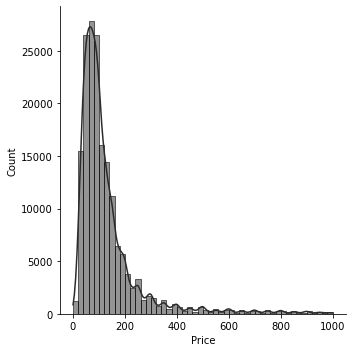

In [356]:
sns.displot(Y, kde=True, bins=50)

Create a scatterplot showing the relationship between host response rate and price

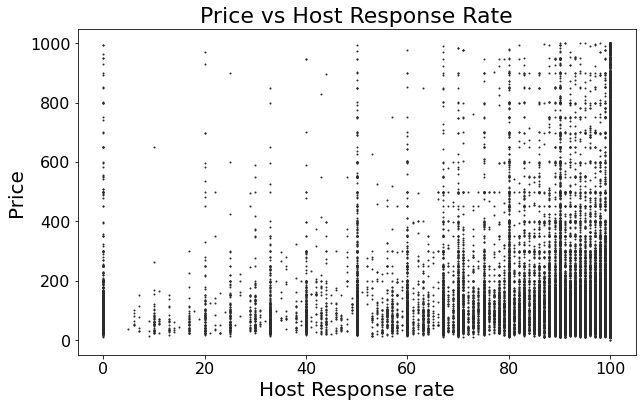

In [841]:
# Create scatterplot
fig, ax = plt.subplots(figsize=(10,6))

Y_array = np.array(Y)
X_array = np.array(Z["Host Response Rate"])

ax.scatter(X_array, Y_array, s = 1)
ax.set_title("Price vs Host Response Rate", fontsize=22)
ax.set_ylabel("Price", fontsize=20)
ax.set_xlabel("Host Response rate", fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=16)

#Download the image
#if not os.path.exists("plots"):
#    os.makedirs("plots")
#fig.savefig("plots/Response_Price", dpi=500)


Create a scatterplot showing the relationship between rating and price

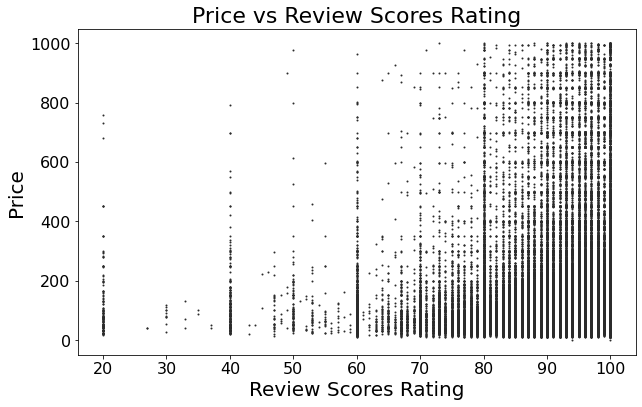

In [842]:
fig, ax = plt.subplots(figsize=(10,6))

Y_array = np.array(Y)
X_array = np.array(Z["Review Scores Rating"])

ax.scatter(X_array, Y_array, s = 1)
ax.set_title("Price vs Review Scores Rating", fontsize=22)
ax.set_ylabel("Price", fontsize=20)
ax.set_xlabel("Review Scores Rating", fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=16)

#if not os.path.exists("plots"):
#    os.makedirs("plots")
#fig.savefig("plots/Rating_Price", dpi=500)

Create boxplots indicating the price distribution for listings with different numbers of bedrooms

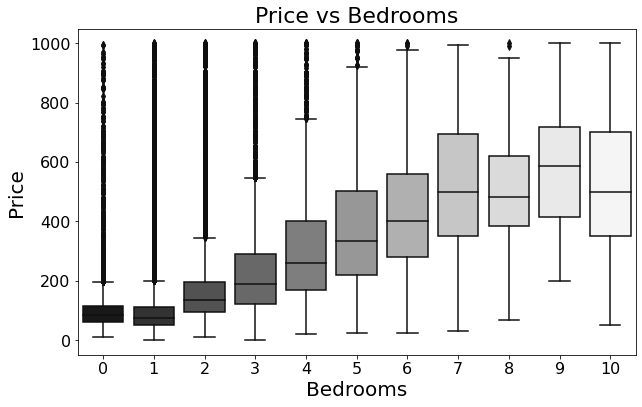

In [843]:
# Create boxplot
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.boxplot(x=Z["Bedrooms"], y=Y, palette="Greys_r")
ax.set_title("Price vs Bedrooms", fontsize=22)
ax.set_xlabel("Bedrooms", fontsize=20)
ax.set_ylabel("Price", fontsize=20)
ticks = ax.get_xticks()
ticks = [int(t) for t in ticks]
ax.set_xticklabels(ticks)
ax.tick_params(axis="both", which="major", labelsize=16)
#fig.savefig("plots/Bedrooms_Price", dpi=500)

Create boxplots indicating the price distribution for listings with different numbers of location ratings

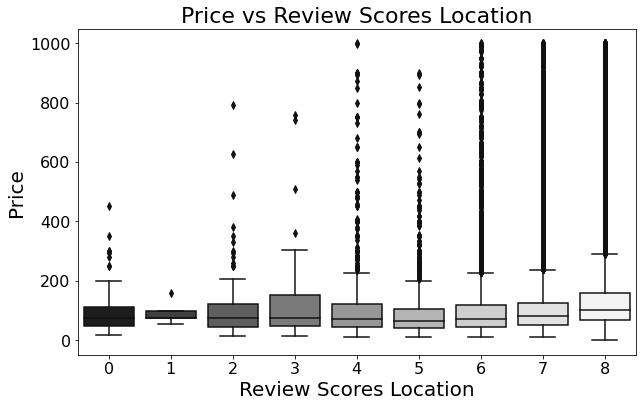

In [844]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.boxplot(x=Z["Review Scores Location"], y=Y, palette="Greys_r")
ax.set_title("Price vs Review Scores Location", fontsize=22)
ax.set_xlabel("Review Scores Location", fontsize=20)
ax.set_ylabel("Price", fontsize=20)
ticks = ax.get_xticks()
ticks = [int(t) for t in ticks]
ax.set_xticklabels(ticks)
ax.tick_params(axis="both", which="major", labelsize=16)
#fig.savefig("plots/Location_Price", dpi=500)

Create boxplots indicating the price distribution for listings with different numbers of beds

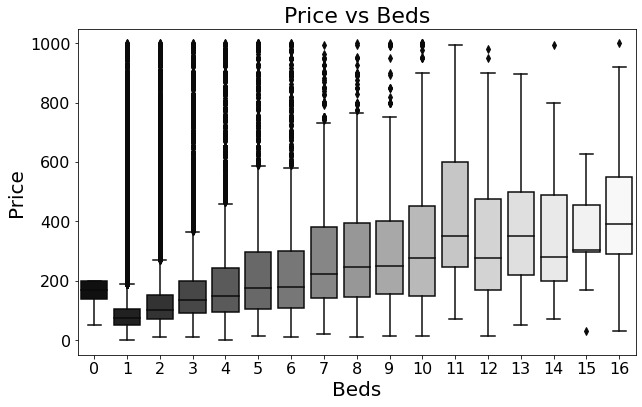

In [845]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.boxplot(x=Z["Beds"], y=Y, palette="Greys_r")
ax.set_title("Price vs Beds", fontsize=22)
ax.set_xlabel("Beds", fontsize=20)
ax.set_ylabel("Price", fontsize=20)
ticks = ax.get_xticks()
ticks = [int(t) for t in ticks]
ax.set_xticklabels(ticks)
ax.tick_params(axis="both", which="major", labelsize=16)
#fig.savefig("plots/Beds_Price", dpi=500)

Create boxplots indicating the price distribution for listings with different roomtypes

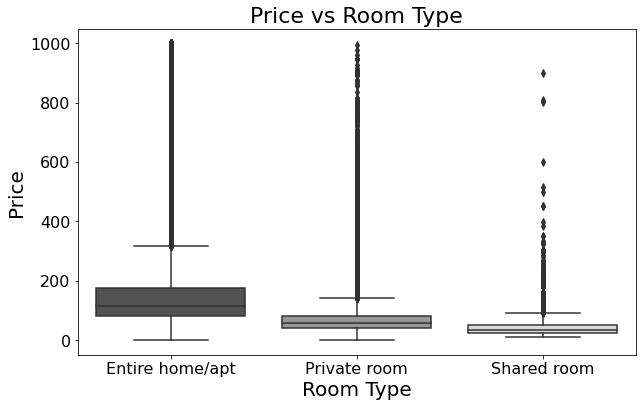

In [846]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.boxplot(x=airbnb5["Room Type"], y=Y, palette="Greys_r")
ax.set_title("Price vs Room Type", fontsize=22)
ax.set_xlabel("Room Type", fontsize=20)
ax.set_ylabel("Price", fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=16)
#fig.savefig("plots/RoomType_Price", dpi=500)

Create boxplots indicating the price distribution for listings in different countries

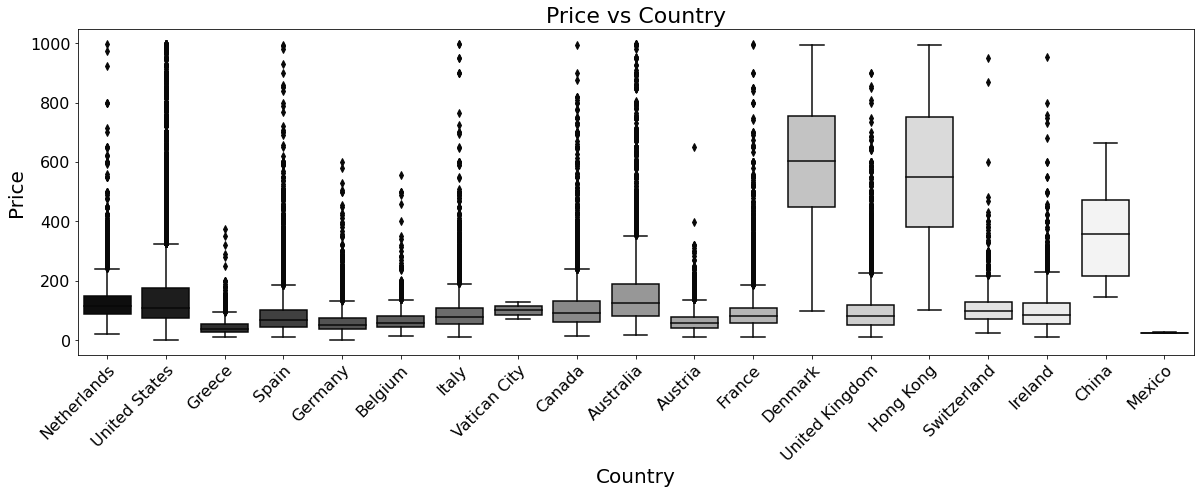

In [847]:
fig, ax = plt.subplots(figsize=(20,6))
ax = sns.boxplot(x=airbnb5["Country"], y=Y, palette="Greys_r")
ax.set_title("Price vs Country", fontsize=22)
ax.set_xlabel("Country", fontsize=20)
ax.set_ylabel("Price", fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=16)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
#fig.savefig("plots/Country_Price", dpi=500)

Create a scatterplot showing the relationship between cleaning fee and price

[[1.    0.756]
 [0.756 1.   ]]


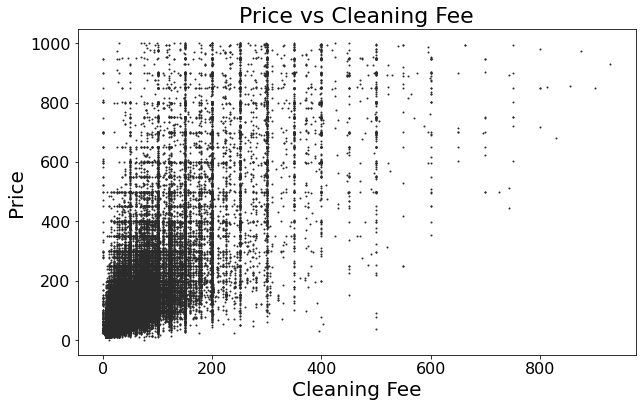

In [848]:
fig, ax = plt.subplots(figsize=(10,6))

Y_array = np.array(Y)
X_array = np.array(airbnb5["Cleaning Fee"])

ax.scatter(X_array, Y_array, s = 1, )
ax.set_title("Price vs Cleaning Fee", fontsize=22)
ax.set_xlabel("Cleaning Fee", fontsize=20)
ax.set_ylabel("Price", fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=16)


print(np.corrcoef(X_array, Y_array))
#fig.savefig("plots/Cleaning_Fee_Price", dpi=500)

Create boxplots indicating the price distribution for listings with different numbers of people they accommodate

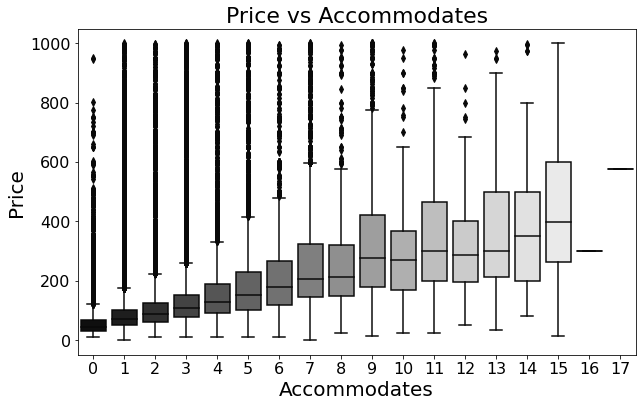

In [849]:
fig = plt.figure(figsize=(10,6))
ax = sns.boxplot(x=Z["Accommodates"], y=Y, palette="Greys_r")
ax.set_title("Price vs Accommodates", fontsize=22)
ax.set_xlabel("Accommodates", fontsize=20)
ax.set_ylabel("Price", fontsize=20)
ticks = ax.get_xticks()
ticks = [int(t) for t in ticks]
ax.set_xticklabels(ticks)

ax.tick_params(axis="both", which="major", labelsize=16)
#fig.savefig("plots/Accommodates_Price", dpi=500)

IMAGE DATA

Display a random image and its shape

(144, 216, 3)


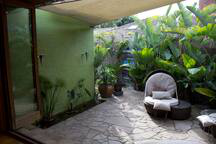

In [85]:
url = airbnb5["Thumbnail Url"].iloc[137589]
response = requests.get(url)
if response.status_code == 200:    
    img = Image.open(BytesIO(response.content))
    img_array = np.array(img)
    print(img_array.shape)
    display(img)

Check shapes of the first fifty images - They are all the same

In [87]:
img_shapes = []
for url in airbnb5.loc[:50,"Thumbnail Url"]:
    response = requests.get(url)
    if response.status_code == 200:    
        img = Image.open(BytesIO(response.content))
        img_array = np.array(img)
        img_shapes.append(img_array.shape)
        img.close()

img_shapes

[(144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3),
 (144, 216, 3)]

Note that only 32 of the 50 URLs led to an image is was available

In [88]:
len(img_shapes)

32

Downloaded images to a folder. I did this in batches of 20000-30000 images over several nights.
Some url links throw an error and images can't be downloaded, corresponding data rows in the data frame have to be filtered out.
Filenames contain the index of the images in order to match them with the corresponding rows later.

In [ ]:
import os
from urllib.parse import urlparse

output_folder = "images"
os.makedirs(output_folder, exist_ok=True)

urls = airbnb5.loc[:20000, "Thumbnail Url"]
for index, url in enumerate(urls):
    # Request image from URL
    response = requests.get(url)
    if response.status_code == 200:
        img = Image.open(BytesIO(response.content))
        # If downloading in batches, adjust index to starting point in airbnb5 (e.g. if downloading [30000:40000, "Thumbnail Url"]
        # adjust index to index = index + 30000)
        index = index + 0
        filename = os.path.join(output_folder,f"image_{index}.jpg")
        # save image
        try:
            if img.mode == "RGB":
                img.save(filename)
                #print(f"saved image {index}")
            else:
                img.convert("RGB")
                img.save(filename)
                #print(f"saved image {index}")
        except Exception as e:
            #print(f"Error: {str(e)}")
            continue

Check if indices match by comparing the downloaded image, with the filename containing index i, with the image from the URL at index i in dataframe airbnb5.

In [58]:
airbnb5.loc[143239, "Thumbnail Url"]

'https://a0.muscache.com/im/pictures/3e2e18e0-6887-4d51-8bde-ff67d2d73b1e.jpg?aki_policy=small'

Load images into a dictionary and extract the index as key

In [298]:
index_image_map = {}

In [ ]:
import os

path = "images/"
all_files = os.listdir(path)

for f in all_files:
    try:
        index = int(f.split("_")[1].split(".")[0])
        image = Image.open(os.path.join(path,f))
        index_image_map[index] = np.array(image)
        image.close()
    except Exception as e:
        #print(f"Error loading {f}: {str(e)}")


135175 of 135271 images could be loaded

In [300]:
len(index_image_map)

135175

Filter out images that are not of shape (144, 216, 3) (1.6%)

In [ ]:
filtered = {}
target_shape = (144, 216, 3)
for index, image in list(index_image_map.items()):
    if image.shape == target_shape:
        filtered[index] = image
    else:
        #print(f"image {index} removed with shape {image.shape}")

In [302]:
len(filtered)

132992

Sort by index

In [303]:
filtered = dict(sorted(filtered.items()))

Create list of images

In [304]:
images = list(filtered.values())
len(images)

132992

Check shapes

In [305]:
shapes = {}
for image in images:
    if image.shape in list(shapes.keys()):
        shapes[image.shape] += 1
    else:
        shapes[image.shape] = 1
shapes

{(144, 216, 3): 132992}

In [306]:
list(filtered.keys())[:20]

[0, 1, 5, 6, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 26, 28, 29, 31, 32]

Filter Z and Y so that rows correspond to images

In [307]:
Z_filtered = Z.iloc[list(filtered.keys()),:]
Z_filtered = Z_filtered.reset_index(drop=True)
print(len(Z_filtered))
Y_filtered = Y.iloc[list(filtered.keys())]
Y_filtered = Y_filtered.reset_index(drop=True)
print(len(Y_filtered))

132992
132992


GENERATE EMBEDDINGS

Load the CLIP Processor and the CLIP model

In [308]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

Pass images into CLIP and obtain similarity scores with "room", "apartment" as well as the image embeddings of size 512

In [ ]:
# Select batch size
batch_size = 128
num_batches = len(images) // batch_size + (len(images) % batch_size != 0)
X = []
similarity = []

# Iterate through batches
for batchx in range(num_batches):
    startx = batchx * batch_size
    endx = min((batchx + 1) * batch_size, len(images))

    # Select batch
    batch_images = images[startx:endx]
    print(f"processing images {startx} to {endx}")

    # Normalize, rescale, and center crop the images
    inputs = processor(text=["soccer", "apartment"], images=batch_images, return_tensors="pt")

    print("calculating similarity")

    # Pass the images through the model
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extract embeddings and similarity scores
    X.extend(outputs.image_embeds)
    similarity.extend(outputs.logits_per_image)
    print(f"batch {batchx + 1} of {num_batches} processed")

In [312]:
len(X)

132992

Check similarity distributions for word "soccer" and "aaprtment" to see if CLIP captures relevant information from the image

In [895]:
similarity_s = [pair[0] for pair in similarity]
similarity_s = np.array(similarity_s)
similarity_ap = [pair[1] for pair in similarity]
similarity_ap = np.array(similarity_ap)


Plot the distribution of scores

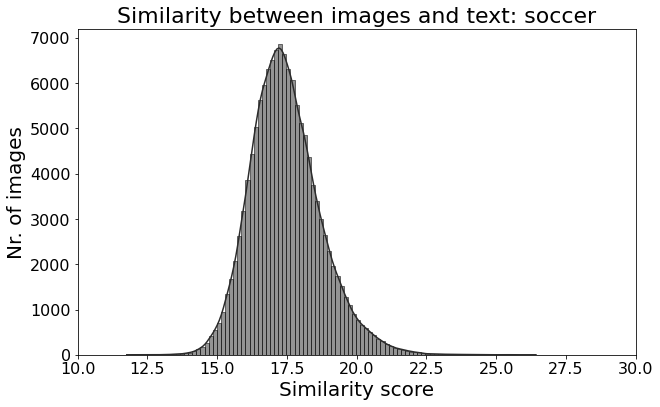

In [896]:
fig, ax = plt.subplots(figsize=(10,6))

ax = sns.histplot(similarity_s, kde=True, bins=100)
ax.set_title("Similarity between images and text: soccer", fontsize=22)
ax.set_xlabel("Similarity score", fontsize=20)
ax.set_xlim(10,30)
ax.set_ylabel("Nr. of images", fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=16)
fig.savefig("plots/Similarity_Soccer", dpi=500)


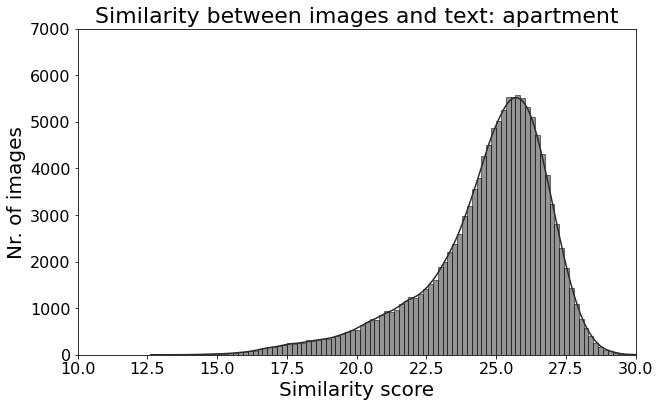

In [429]:
fig, ax = plt.subplots(figsize=(10,6))

ax = sns.histplot(similarity_ap, kde=True, bins=100)
ax.set_title("Similarity between images and text: apartment", fontsize=22)
ax.set_xlabel("Similarity score", fontsize=20)
ax.set_xlim(10,30)
ax.set_ylim(0,7000)
ax.set_ylabel("Nr. of images", fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=16)
fig.savefig("plots/Similarity_Apartment", dpi=500)

Convert embeddings into Dataframe

In [103]:
X_df = [embedding.numpy() for embedding in X]
X_df = pd.DataFrame(X_df)
X_df.shape

(132992, 512)

Check for prices that are 0 and remove them

In [104]:
null_prices = Y_filtered[Y_filtered == 0]
null_prices

72181    0.0
Name: Price, dtype: float64

In [105]:
Y_filtered = Y_filtered.drop(72181, axis=0)
Z_filtered = Z_filtered.drop(72181, axis=0)
X_df = X_df.drop(72181, axis=0)

In [106]:
print(len(Y_filtered), len(Z_filtered), len(X_df))

132991 132991 132991


PREDICTIVE MODELING

Split data into train and test sets

In [112]:
from sklearn.model_selection import train_test_split

X_train, X_test, Z_train, Z_test, Y_train, Y_test = train_test_split(X_df, Z_filtered, Y_filtered, test_size=1/3, random_state=1234)
print(X_train.shape, X_test.shape, Z_train.shape, Z_test.shape, Y_train.shape, Y_test.shape)

(88660, 512) (44331, 512) (88660, 351) (44331, 351) (88660,) (44331,)


Create a split using a smaller sample to check robustness of p-values

Randomly select 10,000 observations

In [172]:
X_df2 = X_df.sample(10000, random_state=1234)
Z_filtered2 = Z_filtered.sample(10000, random_state=1234)
Y_filtered2 = Y_filtered.sample(10000, random_state=1234)
print(len(X_df2), len(Z_filtered2), len(Y_filtered2))

10000 10000 10000


In [443]:
X_train2, X_test2, Z_train2, Z_test2, Y_train2, Y_test2 = train_test_split(X_df2, Z_filtered2, Y_filtered2, test_size=1/3, random_state=1234)
print(X_train2.shape, X_test2.shape, Z_train2.shape, Z_test2.shape, Y_train2.shape, Y_test2.shape)

(6666, 512) (3334, 512) (6666, 351) (3334, 351) (6666,) (3334,)


Normalize continuous variables in Z

In [113]:
from sklearn.preprocessing import StandardScaler

def normalize_Z(Z_train, Z_test):
    scaler = StandardScaler().fit(Z_train.iloc[:,:24])
    Z_train_num = scaler.transform(Z_train.iloc[:,:24])
    Z_test_num = scaler.transform(Z_test.iloc[:,:24])
    Z_train_num = pd.DataFrame(Z_train_num, columns = Z_train.iloc[:,:24].columns)
    Z_test_num = pd.DataFrame(Z_test_num, columns = Z_test.iloc[:,:24].columns)
    Z_train_normal = pd.concat([Z_train_num, Z_train.iloc[:,24:].reset_index(drop=True)], axis=1)
    Z_test_normal = pd.concat([Z_test_num, Z_test.iloc[:,24:].reset_index(drop=True)], axis=1)
    return Z_train_normal, Z_test_normal

In [114]:
Z_train_normal, Z_test_normal = normalize_Z(Z_train, Z_test)

Repeat on smaller dataset

In [444]:
Z_train_normal2, Z_test_normal2 = normalize_Z(Z_train2, Z_test2)

Normalize X

In [115]:
def normalize_X(X_train, X_test):
    scalerX = StandardScaler().fit(X_train)
    X_train_normal = scalerX.transform(X_train)
    X_test_normal = scalerX.transform(X_test)
    X_train_normal = pd.DataFrame(X_train_normal, columns = X_train.columns)
    X_test_normal = pd.DataFrame(X_test_normal, columns = X_test.columns)
    return X_train_normal, X_test_normal

In [116]:
X_train_normal, X_test_normal = normalize_X(X_train, X_test)
X_train_normal.shape

(88660, 512)

Repeat on smaller dataset

In [445]:
X_train_normal2, X_test_normal2 = normalize_X(X_train2, X_test2)

Create combined predictor dataframe ZX

In [117]:
def create_ZX(Z_train, Z_test, X_train, X_test):
    ZX_train = pd.concat([X_train, Z_train], axis=1)
    ZX_test = pd.concat([X_test, Z_test], axis=1)
    return ZX_train, ZX_test

In [118]:
ZX_train_normal, ZX_test_normal = create_ZX(Z_train_normal, Z_test_normal, X_train_normal, X_test_normal)
ZX_train_normal.shape

(88660, 863)

Repeat on smaller dataset

In [446]:
ZX_train_normal2, ZX_test_normal2 = create_ZX(Z_train_normal2, Z_test_normal2, X_train_normal2, X_test_normal2)

Reset index of Y_train and Y_test to match the indices in the normalized predictor dataframes, and log-transform Y

<AxesSubplot:title={'center':'Log-transformed Y'}, xlabel='Price', ylabel='Count'>

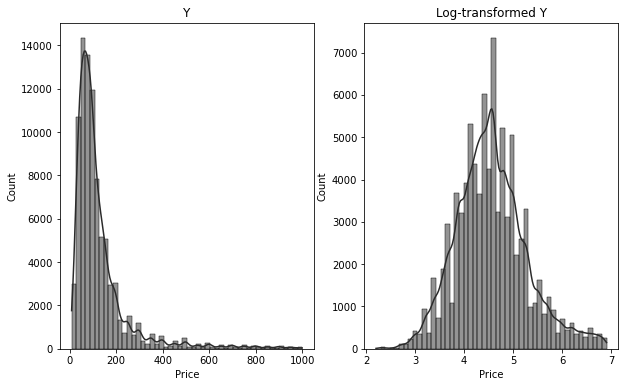

In [897]:
Y_train = Y_train.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)
Y_train_log = np.log(Y_train)
Y_test_log = np.log(Y_test)

fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].set_title("Y")
ax[1].set_title("Log-transformed Y")
sns.histplot(Y_train, kde=True, bins=50, ax=ax[0])
sns.histplot(Y_train_log, kde=True, bins=50, ax=ax[1])

Repeat for the smaller data set

<AxesSubplot:title={'center':'Log-transformed Y - Smaller data set'}, xlabel='Price', ylabel='Count'>

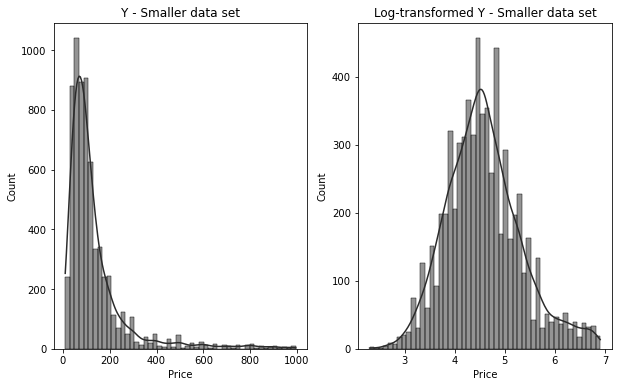

In [447]:
Y_train2 = Y_train2.reset_index(drop=True)
Y_test2 = Y_test2.reset_index(drop=True)
Y_train_log2 = np.log(Y_train2)
Y_test_log2 = np.log(Y_test2)

fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].set_title("Y - Smaller data set")
ax[1].set_title("Log-transformed Y - Smaller data set")
sns.histplot(Y_train2, kde=True, bins=50, ax=ax[0])
sns.histplot(Y_train_log2, kde=True, bins=50, ax=ax[1])

Use a certain variance threshold to perform feature selection. This threshold is chosen to remove as many variables as possible while retaining prediction accuracy. Thresholds of 0.1% and 2% are used

In [762]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=(.999* (1-.999)))
Z_train_normal_sel = vt.fit_transform(Z_train_normal)
print(Z_train_normal.shape, Z_train_normal_sel.shape)
Z_test_normal_sel = Z_test_normal.iloc[:,vt.get_support()]
Z_train_normal_sel = pd.DataFrame(Z_train_normal_sel, columns=Z_test_normal_sel.columns)
Z_test_normal_sel.shape

(88660, 351) (88660, 222)


(44331, 222)

Predict Y from Z using linear regression

In [763]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model_LR = LinearRegression().fit(Z_train_normal_sel, Y_train_log)
print("R-squared: " + str(model_LR.score(Z_train_normal_sel, Y_train_log)))
pred_train_LR = model_LR.predict(Z_train_normal_sel)
train_error_LR = np.sqrt(mean_squared_error(Y_train_log, pred_train_LR))
print("Train error: " + str(train_error_LR))
pred_test_LR = model_LR.predict(Z_test_normal_sel)
test_error_LR = np.sqrt(mean_squared_error(Y_test_log, pred_test_LR))
print("Test error: " + str(test_error_LR))

R-squared: 0.7774056919484424
Train error: 0.34271243972109383
Test error: 0.3455756247582596


Calculate prediction residuals for all data points in the test set

In [764]:
residuals_Z = np.power(Y_test_log - pred_test_LR, 2)
residuals_Z.shape

(44331,)

Perform linear regression on smaller data set

In [791]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=(.9999* (1-.9999)))
Z_train_normal_sel2 = vt.fit_transform(Z_train_normal2)
print(Z_train_normal2.shape, Z_train_normal_sel2.shape)
Z_test_normal_sel2 = Z_test_normal2.iloc[:,vt.get_support()]
Z_train_normal_sel2 = pd.DataFrame(Z_train_normal_sel2, columns=Z_test_normal_sel2.columns)
Z_test_normal_sel2.shape

(6666, 351) (6666, 266)


(3334, 266)

In [792]:
model_LR_small = LinearRegression().fit(Z_train_normal_sel2, Y_train_log2)
print("R-squared: " + str(model_LR_small.score(Z_train_normal_sel2, Y_train_log2)))
pred_train_small = model_LR_small.predict(Z_train_normal_sel2)
train_error_small = np.sqrt(mean_squared_error(Y_train_log2, pred_train_small))
print("Train error: " + str(train_error_small))
pred_test_small = model_LR_small.predict(Z_test_normal_sel2)
test_error_small = np.sqrt(mean_squared_error(Y_test_log2, pred_test_small))
print("Test error: " + str(test_error_small))

R-squared: 0.7911015057179481
Train error: 0.340349911424024
Test error: 5136129862.315968


This yields an unusual high test error. The model is unstable

Changing the variance threshold to .95* (1-.95) leads to a reasonable test error but performance descreases significantly:

Train error: 0.4374100813655196
Test error: 0.43357137378244504

One test observation yields an extrem residual. Removing the observation yields a reasonable test error

In [793]:
residuals_Z_small = np.power(Y_test_log2 - pred_test_small, 2)
residuals_Z_small[residuals_Z_small>10]

31    8.795035e+22
Name: Price, dtype: float64

RMSE when removing this observation

In [794]:
np.sqrt(residuals_Z_small[residuals_Z_small<10].mean())

0.35206932750859843

Look at predictor variables of the extreme observation

In [795]:
obs = Z_test_normal_sel2.iloc[31:33,:]
obs.head()

,Host Response Rate,Host Listings Count,Accommodates,Bathrooms,Bedrooms,Beds,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 30,Availability 60,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Reviews per Month,Host Since,path to entrance lit at night,single level home,iron,crib,smoking allowed,washer,air conditioning,fire extinguisher,pool,coffee maker,cable tv,laptop friendly workspace,cleaning before checkout,disabled parking spot,wide clearance to shower and toilet,children’s dinnerware,hangers,tv,baby bath,wide clearance to bed,other pet(s),keypad,24-hour check-in,bed linens,private living room,lockbox,microwave,doorman,family/kid friendly,washer / dryer,safety card,outlet covers,cooking basics,children’s books and toys,hot tub,firm mattress,refrigerator,translation missing: en.hosting_amenity_49,long term stays allowed,private bathroom,carbon monoxide detector,free parking on street,high chair,internet,extra pillows and blankets,patio or balcony,accessible-height bed,bathtub,pocket wifi,wheelchair accessible,flat smooth pathway to front door,free parking on premises,indoor fireplace,elevator in building,breakfast,gym,dryer,pack ’n play/travel crib,dog(s),stair gates,first aid kit,hair dryer,buzzer/wireless intercom,lake access,lock on bedroom door,dishwasher,pets live on this property,bbq grill,wide doorway,self check-in,ethernet connection,suitable for events,smoke detector,hot water,window guards,shampoo,smartlock,heating,oven,luggage dropoff allowed,waterfront,baby monitor,room-darkening shades,dishes and silverware,kitchen,wireless internet,garden or backyard,pets allowed,table corner guards,fireplace guards,game console,changing table,paid parking off premises,doorman entry,private entrance,stove,smart lock,firm matress,beachfront,cat(s),translation missing: en.hosting_amenity_50,essentials,wide hallway clearance,babysitter recommendations,step-free access,host has profile pic,is location exact,host is superhost,instant bookable,require guest phone verification,require guest profile picture,host identity verified,requires license,manual_online,amex,linkedin,jumio,manual_offline,government_id,google,email,sesame_offline,identity_manual,sesame,facebook,selfie,weibo,offline_government_id,work_email,photographer,reviews,kba,phone,sent_id,Room Type_Private room,Room Type_Shared room,Experiences Offered_family,Experiences Offered_none,Experiences Offered_romantic,Experiences Offered_social,Host Response Time_within a day,Host Response Time_within a few hours,Host Response Time_within an hour,Country_Austria,Country_Belgium,Country_Canada,Country_China,Country_Denmark,Country_France,Country_Germany,Country_Greece,Country_Hong Kong,Country_Ireland,Country_Italy,Country_Netherlands,Country_Spain,Country_Switzerland,Country_United Kingdom,Country_United States,Property Type_Bed & Breakfast,Property Type_Boat,Property Type_Boutique hotel,Property Type_Bungalow,Property Type_Cabin,Property Type_Camper/RV,Property Type_Castle,Property Type_Chalet,Property Type_Condominium,Property Type_Dorm,Property Type_Guest suite,Property Type_Guesthouse,Property Type_Hostel,Property Type_House,Property Type_Loft,Property Type_Other,Property Type_Serviced apartment,Property Type_Townhouse,Property Type_Treehouse,Property Type_Vacation home,Property Type_Villa,Bed Type_Couch,Bed Type_Futon,Bed Type_Pull-out Sofa,Bed Type_Real Bed,Market_Amsterdam,Market_Antwerp,Market_Athens,Market_Austin,Market_Barcelona,Market_Berlin,Market_Boston,Market_Brussels,Market_Byron Bay,Market_Chicago,Market_Copenhagen,Market_D.C.,Market_Denver,Market_Dublin,"Market_East Bay, CA",Market_Edinburgh,Market_Geneva,Market_Gold Coast-Tweed,Market_Hong Kong,Market_Lazio Coast,Market_Lazio Countryside,Market_London,Market_Los Angeles,Market_Madrid,Market_Malibu,Market_Mallor

In [796]:
model_LR_small.predict(obs)

array([-2.966e+11,  4.474e+00])

In [797]:
Y_test_log2[31:33]

31    4.605170
32    4.234107
Name: Price, dtype: float64

This is most likely caused by extreme coefficients. The coefficients are checked in the following and especially the variables "Country" and "Market" have extremely negative coefficients. Note how "Country_Italy" and "Market_Rome" (the extreme observation has these values) have the coefficients -2.965642e+11 and -1.092374e+11, respectively.

In [798]:
summary = pd.DataFrame(Z_train_normal_sel2.columns, model_LR_small.coef_,)
summary

,0
5.874052e-04,Host Response Rate
7.099002e-03,Host Listings Count
1.289760e-01,Accommodates
4.774201e-02,Bathrooms
1.193829e-01,Bedrooms
-3.592309e-02,Beds
9.425631e-02,Cleaning Fee
2.763726e-03,Guests Included
6.485102e-03,Extra People
-2.538464e-02,Minimum Nights


Predict Y from Z and X using linear regression. Use the same variance threshold as above

In [799]:
vt = VarianceThreshold(threshold=(0.999* (1-.999)))
ZX_train_normal_sel = vt.fit_transform(ZX_train_normal)
print(ZX_train_normal.shape, ZX_train_normal_sel.shape)
ZX_test_normal_sel = ZX_test_normal.iloc[:,vt.get_support()]
ZX_train_normal_sel = pd.DataFrame(ZX_train_normal_sel, columns=ZX_test_normal_sel.columns)
ZX_test_normal_sel.shape

(88660, 863) (88660, 734)


(44331, 734)

In [780]:
model_LR2 = LinearRegression().fit(ZX_train_normal_sel, Y_train_log)
print("R-squared: " + str(model_LR2.score(ZX_train_normal_sel, Y_train_log)))
pred_train_LR2 = model_LR2.predict(ZX_train_normal_sel)
train_error_LR2 = np.sqrt(mean_squared_error(Y_train_log, pred_train_LR2))
print("Train error: " + str(train_error_LR2))
pred_test_LR2 = model_LR2.predict(ZX_test_normal_sel)
test_error_LR2 = np.sqrt(mean_squared_error(Y_test_log, pred_test_LR2))
print("Test error: " + str(test_error_LR2))

R-squared: 0.7989738964904287
Train error: 0.32568598377128793
Test error: 0.3302817382048106


Compute residuals

In [781]:
residuals_ZX = np.power(pred_test_LR2 - Y_test_log, 2)
residuals_ZX.shape

(44331,)

Repeat for smaller data set

In [800]:
vt = VarianceThreshold(threshold=(.9999* (1-.9999)))
ZX_train_normal_sel2 = vt.fit_transform(ZX_train_normal2)
print(ZX_train_normal2.shape, ZX_train_normal_sel2.shape)
ZX_test_normal_sel2 = ZX_test_normal2.iloc[:,vt.get_support()]
ZX_train_normal_sel2 = pd.DataFrame(ZX_train_normal_sel2, columns=ZX_test_normal_sel2.columns)
ZX_test_normal_sel2.shape

(6666, 863) (6666, 778)


(3334, 778)

In [801]:
model_LR_small_ZX = LinearRegression().fit(ZX_train_normal_sel2, Y_train_log2)
print("R-squared: " + str(model_LR_small_ZX.score(ZX_train_normal_sel2, Y_train_log2)))
pred_train_small_ZX = model_LR_small_ZX.predict(ZX_train_normal_sel2)
train_error_small_ZX = np.sqrt(mean_squared_error(Y_train_log2, pred_train_small_ZX))
print("Train error: " + str(train_error_small_ZX))
pred_test_small_ZX = model_LR_small_ZX.predict(ZX_test_normal_sel2)
test_error_small_ZX = np.sqrt(mean_squared_error(Y_test_log2, pred_test_small_ZX))
print("Test error: " + str(test_error_small_ZX))

R-squared: 0.8279631132028235
Train error: 0.3088650546814747
Test error: 912636735.0875082


The test error is extremely high again, caused by the same observation

In [802]:
residuals_ZX_small = np.power(Y_test_log2 - pred_test_small_ZX, 2)
residuals_ZX_small[residuals_ZX_small>10]

31    2.776908e+21
Name: Price, dtype: float64

Error without the observation

In [803]:
np.sqrt(np.mean(residuals_ZX_small[residuals_ZX_small<10]))

0.35076072714770473

Check distribution of residuals when using the entire dataset. The distribution is highly skewed and the Wilcoxon test is chosen

Text(0.5, 1.0, 'Residuals f(Y | Z, X)')

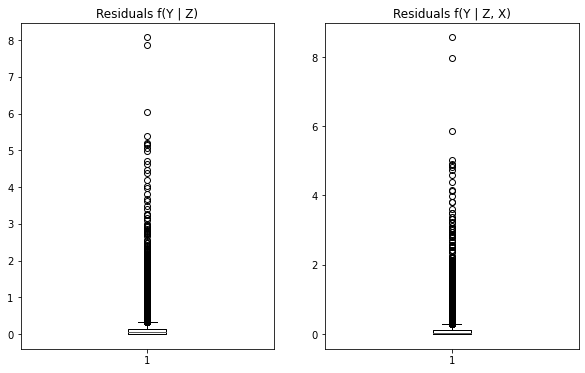

In [898]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.boxplot(residuals_Z)
plt.title("Residuals f(Y | Z)")
plt.subplot(1, 2, 2)
plt.boxplot(residuals_ZX)
plt.title("Residuals f(Y | Z, X)")

Perform Signed Rank Wilcoxon Test to test for conditional independence. The p-value is extremely small (entire dataset).

In [759]:
from scipy.stats import wilcoxon

stat, p = wilcoxon(residuals_ZX, residuals_Z, alternative="less")
print(f"P-Value: {p}")

P-Value: 6.3288366454364e-93


Repeat this for the small data set (3334 test observations) to check robustness of the p-value to the number of observations. The test is still significant but the p-value is higher as before, which was expected.

In [805]:
stat, p = wilcoxon(residuals_ZX_small, residuals_Z_small, alternative="less")
print(f"P-Value: {p}")

P-Value: 0.026978901873453007


Entire dataset

Perform 10x10 Cross Validation to more accurately estimate linear regression test RMSE

In [770]:
Z_normal = pd.concat([Z_train_normal_sel, Z_test_normal_sel], axis=0)
ZX_normal = pd.concat([ZX_train_normal_sel, ZX_test_normal_sel], axis=0)
Y_log = pd.concat([Y_train_log, Y_test_log], axis=0)

f(Y | Z)

In [771]:
from sklearn.model_selection import cross_val_score, RepeatedKFold

model = LinearRegression()
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=100)
scores_LR_Z = cross_val_score(model, Z_normal, Y_log, scoring="neg_mean_squared_error", cv=cv)
scores_LR_Z = np.sqrt(abs(scores_LR_Z))

f(Y | X,Z)

In [772]:
scores_LR_ZX = cross_val_score(model, ZX_normal, Y_log, scoring="neg_mean_squared_error", cv=cv)
scores_LR_ZX = np.sqrt(abs(scores_LR_ZX))

Test cross validation test errors of f(Y | X,Z) and f(Y | X,Z) on conditional independence 

In [773]:
scores_LR_Z

array([3.482e-01, 3.463e-01, 3.379e-01, 3.448e-01, 3.433e-01, 1.782e+09,
       3.445e-01, 3.442e-01, 3.442e-01, 3.465e-01, 3.417e-01, 3.441e-01,
       3.474e-01, 3.440e-01, 3.493e-01, 3.435e-01, 3.455e-01, 3.414e-01,
       9.001e+09, 3.386e-01, 3.441e-01, 3.470e-01, 3.485e-01, 3.450e-01,
       3.445e-01, 3.426e-01, 3.439e-01, 3.422e-01, 3.410e-01, 3.431e-01,
       3.465e-01, 3.434e-01, 3.408e-01, 3.434e-01, 3.434e-01, 3.431e-01,
       3.441e-01, 3.489e-01, 3.419e-01, 3.461e-01, 3.452e-01, 3.458e-01,
       5.982e+08, 3.418e-01, 3.417e-01, 3.495e-01, 3.383e-01, 3.425e-01,
       3.449e-01, 3.497e-01, 3.370e-01, 9.139e+08, 3.446e-01, 3.407e-01,
       3.465e-01, 3.445e-01, 3.486e-01, 3.420e-01, 3.465e-01, 3.432e-01,
       3.458e-01, 3.455e-01, 3.404e-01, 3.465e-01, 3.421e-01, 3.456e-01,
       3.418e-01, 6.685e+08, 3.503e-01, 3.409e-01, 3.471e-01, 1.671e+08,
       3.394e-01, 3.461e-01, 3.413e-01, 3.438e-01, 3.429e-01, 3.441e-01,
       3.452e-01, 3.458e-01, 3.462e-01, 3.403e-01, 

Check length of scores and average of RMSEs. For the unstable 0.1% threshold model, exclude unusually high RMSEs for comparison purposes

In [774]:
print(len(scores_LR_Z[scores_LR_Z<1]))
print(np.mean(scores_LR_Z[scores_LR_Z<1]))

92

Note how some RMSEs have extreme values for the 0.1% threshold model, this reinforces the problem seen on the smaller data set. The model seems to be unstable

In [776]:
scores_LR_ZX

array([0.333, 0.33 , 0.324, 0.33 , 0.326, 0.327, 0.331, 0.329, 0.329,
       0.331, 0.327, 0.328, 0.332, 0.329, 0.333, 0.328, 0.331, 0.326,
       0.332, 0.325, 0.329, 0.331, 0.332, 0.328, 0.33 , 0.33 , 0.329,
       0.327, 0.327, 0.327, 0.333, 0.329, 0.325, 0.328, 0.328, 0.326,
       0.33 , 0.332, 0.327, 0.332, 0.331, 0.33 , 0.329, 0.326, 0.327,
       0.334, 0.322, 0.327, 0.33 , 0.333, 0.322, 0.331, 0.33 , 0.325,
       0.332, 0.331, 0.332, 0.327, 0.332, 0.328, 0.331, 0.33 , 0.325,
       0.331, 0.327, 0.332, 0.327, 0.327, 0.335, 0.326, 0.332, 0.331,
       0.324, 0.329, 0.328, 0.329, 0.329, 0.33 , 0.327, 0.33 , 0.331,
       0.326, 0.33 , 0.33 , 0.332, 0.328, 0.33 , 0.33 , 0.325, 0.327,
       0.325, 0.328, 0.336, 0.328, 0.325, 0.328, 0.334, 0.333, 0.33 ,
       0.323])

In [777]:
np.mean(scores_LR_ZX)

0.3289652509941102

Perform a Wilcoxon Test (use only the MSEs below one if the model is unstable): The p-value is almost 0, suggesting conditional dependence

In [778]:
from scipy.stats import wilcoxon

stat, p_value = wilcoxon(scores_LR_ZX[scores_LR_Z<1], scores_LR_Z[scores_LR_Z<1], alternative="less")
print(f"P-Value: {p_value}")

P-Value: 4.074890798662477e-17


Predict the listing prices from the images only using linear regression

In [97]:
model_LR3 = LinearRegression().fit(X_train_normal, Y_train_log)
print("R-squared: " + str(model_LR3.score(X_train_normal, Y_train_log)))
pred_train_LR3 = model_LR3.predict(X_train_normal)
train_error_LR3 = np.sqrt(mean_squared_error(Y_train_log, pred_train_LR3))
print("Train error: " + str(train_error_LR3))
pred_test_LR3 = model_LR3.predict(X_test_normal)
test_error_LR3 = np.sqrt(mean_squared_error(Y_test_log, pred_test_LR3))
print("Test error: " + str(test_error_LR3))

R-squared: 0.21605961823243192
Train error: 0.6431530881844674
Test error: 0.6507820645167274


Repeat cross validation on smaller data set

In [457]:
Z_normal2 = pd.concat([Z_train_normal_sel2, Z_test_normal_sel2], axis=0)
ZX_normal2 = pd.concat([ZX_train_normal_sel2, ZX_test_normal_sel2], axis=0)
Y_log2 = pd.concat([Y_train_log2, Y_test_log2], axis=0)

In [459]:
model = LinearRegression()
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=100)
scores_LR_Z_small = cross_val_score(model, Z_normal2, Y_log2, scoring="neg_mean_squared_error", cv=cv)
scores_LR_Z_small = np.sqrt(abs(scores_LR_Z_small))

In [460]:
scores_LR_ZX_small = cross_val_score(model, ZX_normal2, Y_log2, scoring="neg_mean_squared_error", cv=cv)
scores_LR_ZX_small = np.sqrt(abs(scores_LR_ZX_small))

First model is extremely unstable causing very unusual RMSEs when using all variables. More data might be necessary

In [461]:
scores_LR_Z_small

array([3.49709159e-01, 3.38586922e-01, 3.32289773e+08, 2.09758249e+05,
       1.99396848e+05, 5.99002048e+09, 3.54888039e-01, 3.65503013e-01,
       4.41363076e+09, 1.12673348e+08, 3.69587341e-01, 3.48282670e-01,
       3.61281006e-01, 5.51718777e+07, 7.85953541e+08, 1.19833036e+09,
       2.53633383e+08, 3.22768224e+09, 3.63489319e-01, 1.14430469e+05,
       1.98302555e+09, 7.97033010e+08, 2.04929448e+08, 1.04705445e+08,
       3.59354006e-01, 3.46520283e-01, 3.57994566e-01, 1.99024356e+09,
       8.98833686e+08, 3.47253775e+08, 1.91106088e+01, 3.73062057e-01,
       1.01102710e+09, 2.49371198e+09, 6.12035661e+08, 3.97334302e+08,
       7.35128345e+08, 1.89369120e+08, 3.61507399e-01, 6.55391268e+09,
       3.54460667e-01, 4.07096687e+08, 3.10646203e+05, 9.59571288e+08,
       1.28791552e+08, 2.06130876e+01, 4.31754237e+08, 1.37764811e+08,
       3.26133045e-01, 3.73507103e-01, 3.52659813e-01, 3.61112591e-01,
       9.08233540e+09, 3.45129439e-01, 3.45823396e-01, 4.11742976e+04,
      

In [462]:
scores_LR_ZX_small

array([3.42184495e-01, 3.30840936e-01, 7.60653308e+09, 1.27385813e+06,
       3.50154537e-01, 3.58205944e-01, 3.50438449e-01, 3.54146280e-01,
       3.41245637e-01, 3.35589111e-01, 3.56457422e-01, 3.41749106e-01,
       3.55059355e-01, 3.44207370e-01, 3.44560010e-01, 3.48566994e-01,
       3.52837272e-01, 3.56835465e-01, 3.60252609e-01, 3.30088306e-01,
       3.65308848e-01, 3.63321662e-01, 1.34147123e+08, 3.41801683e-01,
       3.52166849e-01, 3.36356345e-01, 3.46372856e-01, 3.19774225e-01,
       4.76594010e+09, 3.47238846e-01, 2.35203532e+01, 3.71496247e-01,
       3.39520545e-01, 3.61692398e+08, 9.48810195e+07, 3.42421209e-01,
       3.46587573e-01, 3.44215809e-01, 3.53525363e-01, 6.22313658e+08,
       3.53874685e-01, 3.04799928e+09, 3.48692880e-01, 1.88411450e+09,
       3.44761037e-01, 2.79778620e+01, 2.24430764e+08, 3.34627339e+07,
       3.17897801e-01, 3.69721099e-01, 3.43611980e-01, 3.60649611e-01,
       3.50321999e-01, 3.43578719e-01, 3.46712079e-01, 3.53289861e-01,
      

Principal Component Analysis. Many values were tried but all of them performed worse than linear regression

In [463]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
Z_train_pca = pca.fit_transform(Z_train_normal)
Z_test_pca = pca.transform(Z_test_normal)
pca.n_components_

123

In [464]:
pca2 = PCA(0.99)
ZX_train_pca = pca2.fit_transform(ZX_train_normal)
ZX_test_pca = pca2.transform(ZX_test_normal)
pca2.n_components_

495

Linear Regression using PCA - Results are worse that simple linear regression results in both cases (especially when including Z and X)

In [465]:
model_LR4 = LinearRegression().fit(Z_train_pca, Y_train_log)
print("R-squared: " + str(model_LR4.score(Z_train_pca, Y_train_log)))
pred_train_LR4 = model_LR4.predict(Z_train_pca)
train_error_LR4 = np.sqrt(mean_squared_error(Y_train_log, pred_train_LR4))
print("Train error: " + str(train_error_LR4))
pred_test_LR4 = model_LR4.predict(Z_test_pca)
test_error_LR4 = np.sqrt(mean_squared_error(Y_test_log, pred_test_LR4))
print("Test error: " + str(test_error_LR4))

R-squared: 0.7186971389908205
Train error: 0.38526531866398367
Test error: 0.3878629172060481


In [466]:
model_LR5 = LinearRegression().fit(ZX_train_pca, Y_train_log)
print("R-squared: " + str(model_LR5.score(ZX_train_pca, Y_train_log)))
pred_train_LR5 = model_LR5.predict(ZX_train_pca)
train_error_LR5 = np.sqrt(mean_squared_error(Y_train_log, pred_train_LR5))
print("Train error: " + str(train_error_LR5))
pred_test_LR5 = model_LR5.predict(ZX_test_pca)
test_error_LR5 = np.sqrt(mean_squared_error(Y_test_log, pred_test_LR5))
print("Test error: " + str(test_error_LR5))

R-squared: 0.6671777630877385
Train error: 0.41906270197755285
Test error: 0.4260103581985875


PREDICTIVE CONDITIONAL INDEPENDENCE TESTING

Fast Conditional Independence Test using fcit package

In [467]:
pip install fcit

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [468]:
from fcit import fcit

Create X, Z, and Y from the previous train test split. This ensures that the rows are randomly permuted in the same way in each dataframe

In [632]:
ZX_DT = pd.concat([ZX_train_normal, ZX_test_normal], axis=0)
X_DT = np.array(ZX_DT.iloc[:,:512])
Z_DT = np.array(ZX_DT.iloc[:,512:])
Y_DT = pd.concat([Y_train, Y_test], axis=0)
Y_DT = np.array(Y_DT).reshape((-1,1))

Repeat on smaller data set

In [806]:
ZX_DT2 = pd.concat([ZX_train_normal2, ZX_test_normal2], axis=0)
X_DT2 = np.array(ZX_DT2.iloc[:,:512])
Z_DT2 = np.array(ZX_DT2.iloc[:,512:])
Y_DT2 = pd.concat([Y_train2, Y_test2], axis=0)
Y_DT2 = np.array(Y_DT2).reshape((-1,1))

Conditional independence test using the optimal decision tree (fcit package)

In [633]:
p_value = fcit.test(X_DT, Y_DT, Z=Z_DT, verbose = True)
p_value

min_samples_split: 0.2.
min_samples_split: 0.4.
D0 statistics: [0.977 1.015 1.057 0.991 0.989 1.057 0.997 1.027]
D1 statistics: [0.914 0.937 0.986 0.912 0.922 0.987 0.932 0.941]



2.262902127421848e-08

Robustness check on smaller data set

In [807]:
p_value = fcit.test(X_DT2, Y_DT2, Z=Z_DT2, verbose = True)
p_value

min_samples_split: 0.4.
min_samples_split: 0.4.
D0 statistics: [1.148 1.041 1.275 1.096 0.974 1.183 0.948 1.071]
D1 statistics: [1.067 0.993 1.002 0.944 0.841 1.033 0.835 0.985]



0.00044145342243865016

Manually download package mlxtend from https://zenodo.org/records/5398901, as pip installation resulted in a server related error

In [480]:
import sys

path_mlxtend = "/home/RDC/karpfvin/Schreibtisch/Object_importance/rasbt-mlxtend-6585e23/"
sys.path.append(path_mlxtend)

import mlxtend

In [481]:
pip install pcit

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [482]:
from pcit import IndependenceTest

PCIT using stacking

In [426]:
IndependenceTest.PCIT(Y_log, X_DT, z=Z_DT, symmetric=False)

(array([1.]),
 True,
 array([(-0.03583631829969727, -0.031995973506812936, -0.0281556287139286)],
       dtype=object))

PCIT using multiplexing

In [483]:
from pcit.MetaEstimator import MetaEstimator

In [107]:
estimator0 = MetaEstimator(method="multiplexing")
IndependenceTest.PCIT(Y_log, X_DT, z=Z_DT, estimator=estimator0, symmetric=False)

(array([2.396e-20]),
 False,
 array([(-0.0017889371824774008, 0.0018278286585500791, 0.005444594499577558)],
       dtype=object))

Use get_resid() function for insights into prediction performance

Get residuals for approximated optimal prediction functional f(Y | Z)

In [643]:
import random
random.seed(42)

# Multiplexing
estimator1 = MetaEstimator(method="multiplexing")
resid1 = estimator1.get_resid(Z_train_normal, Z_test_normal, Y_train_log, Y_test_log)

In [650]:
# Stacking
estimator3 = MetaEstimator(method="stacking")
resid3 = estimator3.get_resid(Z_train_normal, Z_test_normal, Y_train_log, Y_test_log)

In [645]:
np.sqrt(np.mean(resid1))

0.3518467532212895

In [653]:
np.sqrt(np.mean(resid3))

0.33440527035464906

Get residuals for approximated optimal prediction functional f(Y | Z, X)

In [644]:
# Multiplexing
estimator2 = MetaEstimator(method="multiplexing")
resid2 = estimator2.get_resid(ZX_train_normal, ZX_test_normal, Y_train_log, Y_test_log)

In [646]:
np.sqrt(np.mean(resid2))

0.3498656229876316

In [651]:
# Stacking
estimator4 = MetaEstimator(method="stacking")
resid4 = estimator4.get_resid(ZX_train_normal, ZX_test_normal, Y_train_log, Y_test_log)

In [652]:
np.sqrt(np.mean(resid4))

0.3644977690849769

Look at distribution of residuals for entire dataset

Text(0.5, 1.0, 'Residuals f(Y | Z, X)')

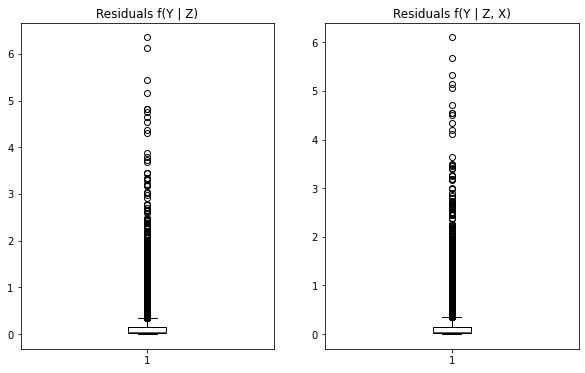

In [900]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.boxplot(resid1)
plt.title("Residuals f(Y | Z)")
plt.subplot(1, 2, 2)
plt.boxplot(resid2)
plt.title("Residuals f(Y | Z, X)")

Perform one-sided Wilcoxon Test on the loss residuals (Multiplexing)

In [713]:
from scipy.stats import wilcoxon

stat, pvalue = wilcoxon(resid2, resid1, alternative="less")
print(f"P-Value: {pvalue}")

P-Value: 9.78181000116628e-16


Perform one-sided Wilcoxon Test on the loss residuals (Stacking)

In [714]:
from scipy.stats import wilcoxon

stat, pvalue = wilcoxon(resid4, resid3, alternative="less")
print(f"P-Value: {pvalue}")

P-Value: 1.0


OUTLOOK - THIS APPROACH DID NOT PERFORM WELL

Image embeddings using regression adapted EfficientNet B4

In [789]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import models, transforms
import time
from tempfile import TemporaryDirectory
cudnn.benchmark = True
plt.ion()

Define function to train the model

In [73]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device="cuda:1", num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_weights_path = os.path.join(tempdir, "best_model_weights.pt")

        torch.save(model.state_dict(), best_model_weights_path)
        # Set best loss to infinity
        best_loss = float("inf")

        # Iterate through epochs
        for epoch in range(num_epochs):
            print(f"Epoch {epoch}/{num_epochs - 1}")
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ["train", "val"]:
                if phase == "train":
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                
                running_loss = 0.0

                # Iterate over data.
                print(phase)
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels.view(-1, 1)).to(device)

                        # Backward + optimize only if in training phase
                        if phase == "train":
                            loss.backward()
                            nn.utils.clip_grad_norm_(model.parameters(), 5.0).to(device)
                            optimizer.step()

                    # Get loss statistics
                    running_loss += loss.item() * inputs.size(0)
                    
                if phase == "train":
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                print(f"{phase} Loss: {epoch_loss:.4f}")

                # Save best paramteres
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_weights_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Loss: {best_loss:4f}')

        # Load best model weights and return trained model
        model.load_state_dict(torch.load(best_model_weights_path))
    return model

Randomly shuffle images before splitting into train, validation, abd test set and store keys for Z and Y

In [45]:
import random

random.seed(100)

shuffled_images = dict(random.sample(filtered.items(), len(filtered)))

image_data = list(shuffled_images.values())
keys = list(shuffled_images.keys())

Normalize pixel values with mean and std from Imagenet

In [46]:
from torchvision import models, transforms

transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image_data = [transforms(image) for image in image_data]


In [47]:
image_data[0].shape

torch.Size([3, 144, 216])

Define custom data set class

In [48]:
from torch.utils.data import Dataset, Subset

class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        return image, label

In [49]:
labels = torch.FloatTensor(Y.loc[keys])
labels.dtype
labels[0]

tensor(341.)

Create train, validation, and test dataset

In [50]:
dataset = CustomDataset(image_data, labels)

train_ratio = 0.4
val_ratio = 0.1
test_ratio = 0.5
train_split = int(train_ratio * len(dataset))
val_split = int((train_ratio + val_ratio) * len(dataset))

train_dataset = Subset(dataset,np.arange(0,train_split))
val_dataset = Subset(dataset, np.arange(train_split,val_split))
test_dataset = Subset(dataset, np.arange(val_split,len(dataset)))
print(len(train_dataset), len(val_dataset))

53196 13300


Define model and replace classification head with regression head

In [790]:
model = models.efficientnet_b4(weights="IMAGENET1K_V1")
classification_head = model.classifier

print(classification_head)
regression_head = nn.Sequential(
    nn.Dropout(p=0.4, inplace=True),
    nn.Linear(1792, 512),
    nn.ReLU(),
    nn.Linear(512, 1)
)
model.classifier = regression_head
print(model.classifier)

Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=1792, out_features=1000, bias=True)
)
Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=1792, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=1, bias=True)
)


Create dataloader, define loss function, batch size, optimizer, and learning rate scheduler

In [90]:
from torch.optim import lr_scheduler

batch_size = 256

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False, pin_memory=True)
data_loaders = {
    "train": train_loader, 
    "val": val_loader}
# Transfer model to CPU
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lrscheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dataset_sizes = {"train": len(train_dataset), "val": len(val_dataset)}

Train the model

In [91]:
trained_model = train_model(model, criterion, optimizer, exp_lrscheduler,
                            dataloaders=data_loaders,
                            dataset_sizes=dataset_sizes, num_epochs=25)

Epoch 0/24
----------
train
train Loss: 23840.5432
val
val Loss: 16818.4123

Epoch 1/24
----------
train
train Loss: 17417.4837
val
val Loss: 16590.2431

Epoch 2/24
----------
train
train Loss: 17186.9618
val
val Loss: 16451.0158

Epoch 3/24
----------
train
train Loss: 17043.5067
val
val Loss: 16329.0259

Epoch 4/24
----------
train
train Loss: 16887.7808
val
val Loss: 16204.3863

Epoch 5/24
----------
train
train Loss: 16770.7753
val
val Loss: 16107.8942

Epoch 6/24
----------
train
train Loss: 16659.5738
val
val Loss: 16067.0982

Epoch 7/24
----------
train
train Loss: 16590.7341
val
val Loss: 16076.5444

Epoch 8/24
----------
train
train Loss: 16576.7751
val
val Loss: 16060.2549

Epoch 9/24
----------
train
train Loss: 16577.4098
val
val Loss: 16057.5745

Epoch 10/24
----------
train
train Loss: 16591.2918
val
val Loss: 16042.4673

Epoch 11/24
----------
train
train Loss: 16558.5292
val
val Loss: 16064.2083

Epoch 12/24
----------
train
train Loss: 16538.6016
val
val Loss: 16034.42

Replace last layer and ReLu with identity layers to get embeddings

In [100]:
trained_model.classifier[2] = nn.Identity()
trained_model.classifier[3] = nn.Identity()
trained_model.classifier
#[:-1]

Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=1792, out_features=1000, bias=True)
  (2): ReLU()
  (3): Linear(in_features=1000, out_features=256, bias=True)
  (4): Identity()
  (5): Identity()
)

Get embeddings for test data

In [101]:
with torch.no_grad():
    embeddings = []
    trained_model.eval()
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, pin_memory=True)
    for inputs, labels in test_loader:
        inputs = inputs.to("cuda:1")
        embed = trained_model(inputs)
        embeddings.extend(embed)

In [102]:
len(embeddings)

66496

In [103]:
embeddings = [embedding.cpu().numpy() for embedding in embeddings]
embeddings = np.array(embeddings)

The embeddings can be tested by fitting a regression model to the embeddings and the test prices. This was tried in the linear regression part, where the price was predicted using only the CLIP embeddings. The EfficientNet embeddings performed worse.